In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.environment import Particle

In [6]:
T = 293
p = 1e-6
R = 147e-9
rho = 2200
index_refraction = 1.4440
tweezer_wavelength = 1.55e-6
tweezer_power = 200e-3
tweezer_waist = 0.6e-6
cavity_waist = 100e-6
cavity_length = 50e-3
m_p = 4 / 3 * np.pi * R**3 * rho
v_gas = np.sqrt(3 * ct.kb * T / ct.m_gas)
Nm = rho / (ct.amu * 60.08)  # SiO2 molecular density
tweezer_freq = 2 * np.pi * ct.c / tweezer_wavelength
pol_permit_ratio = (
    3 / Nm * (index_refraction**2 - 1) / (index_refraction**2 + 2)
)  # from C-M
gamma = 15.8 * R**2 * p / (m_p * v_gas)
omega = (
    np.sqrt(12 / np.pi)
    * np.sqrt((index_refraction**2 - 1) / (index_refraction**2 + 2)) ** 3
    * np.sqrt(tweezer_power)
    / (tweezer_waist**2 * np.sqrt(rho * ct.c))
)
eta_detec = 0.178
period = 2 * np.pi / omega
delta_t = 1e-9

#control_step = 30  # defined as int, number of time steps of simulation necessary to compute the control policy
t = np.arange(0, 3 * period, delta_t)
N = t.shape[0]


In [138]:
import numpy as np
import single_photons.utils.constants as ct


class Particle:
    def __init__(
        self, omega, gamma, coupling, eta_detection=1, radius=147e-9, rho=2200, T=293
    ):
        self.__omega__ = omega
        self.__gamma__ = gamma
        self.T = T
        self.A = np.array([[0, self.__omega__], [-self.__omega__, -self.__gamma__]])
        self.B = np.array([[0], [1]])
        self.laser_omega = 2*np.pi*ct.c/(1084e-9)
        self.G = np.array([[0], [1]])
        self.backaction = np.sqrt(4 * np.pi * coupling)
        self.eta_det = eta_detection
        self._m_ = rho * 4 * np.pi * np.power(radius, 3) / 3
        self.zp_x = np.sqrt(ct.hbar / (2 * omega * self._m_))
        self.zp_p = np.sqrt(omega * ct.hbar * self._m_ / 2)
        self.nl = ct.hbar*self.__omega__/(ct.kb*self.T)
        self.C = np.array([[np.sqrt(16*np.pi*coupling*eta_detection), 0]])*self.zp_x
        # self.C = np.array([[4, 0]])
        self.thermal_force_std = np.sqrt(4 * self.__gamma__ * self._m_ * ct.kb * T)/self.zp_p
        self.backaction_std = self.backaction/ self.zp_p

    def __backaction_fluctuation__(self):
        return self.backaction * (
            np.sqrt(self.eta_det) * np.random.normal()
            + np.sqrt(1 - self.eta_det) * np.random.normal()
        )

    def step(self, states, control=0.0, delta_t=50e-2):
        if states.size > 2:
            raise ValueError(
                "States size for this specific system is equal to two \
                (position and velocity)"
            )
        backaction_force = self.__backaction_fluctuation__()
        thermal_force = self.thermal_force_std* np.random.normal()
        state_dot = np.matmul(self.A, states) + self.B * control
        states = (
            states
            + state_dot * delta_t
            + self.G * np.sqrt(delta_t) * (thermal_force - backaction_force)
        )
        return states

In [139]:
import numpy as np


class KalmanFilter:
     
    def __init__(self,x0,P0,A,B,C,Q,R):
        '''
          x0 - initial guess of the state vector 
         P0 - initial guess of the covariance matrix of the state estimation error
         A,B,C - system matrices describing the system model
         Q - covariance matrix of the process noise 
         R - covariance matrix of the measurement noise
        '''    
        self.x0=x0
        self.P0=P0
        self.A=A
        self.B=B
        self.C=C
        self.Q=Q
        self.R=R
        self.t_i=0
        self.estimates_aposteriori = [x0]
        self.estimates_apriori = []    
        self.error_covariance_aposteriori = [P0]
        self.error_covariance_apriori = []
        self.gainMatrices=[]
        self.errors=[]
         
    def propagate_dynamics(self,inputValue):
         
        xk_minus=self.A*self.estimates_aposteriori[self.t_i]+self.B*inputValue
        Pk_minus=self.A*self.error_covariance_aposteriori[self.t_i]*(self.A.T)+self.Q
        self.estimates_apriori.append(xk_minus)
        self.error_covariance_apriori.append(Pk_minus)         
        self.t_i=self.t_i+1
     
    def compute_aposteriori(self,currentMeasurement):
        Kk=self.error_covariance_apriori[self.t_i-1]*(self.C.T)*np.linalg.pinv(self.R+self.C*self.error_covariance_apriori[self.t_i-1]*(self.C.T))
        error_k=currentMeasurement-self.C*self.estimates_apriori[self.t_i-1]
        xk_plus=self.estimates_apriori[self.t_i-1]+Kk*error_k
        IminusKkC=np.matrix(np.eye(self.x0.shape[0]))-Kk*self.C
        Pk_plus=IminusKkC*self.error_covariance_apriori[self.t_i-1]*(IminusKkC.T)+Kk*(self.R)*(Kk.T)
        self.gainMatrices.append(Kk)
        self.errors.append(error_k)
        self.estimates_aposteriori.append(xk_plus)
        self.error_covariance_aposteriori.append(Pk_plus)

In [140]:
env.backaction

9.162060669080906e-21

In [141]:
coupling = 6.68e-42
env = Particle(omega, gamma, coupling, eta_detection=eta_detec)

In [142]:
variance_process = 4 * ct.kb * env.T * env.__gamma__ * env._m_ / (env.zp_p**2)
variance_process = variance_process + np.power(env.backaction / env.zp_p, 2)
std_detection = 1

In [143]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [144]:
Ad = np.eye(2)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [145]:
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[100],[0.]])
K = np.array([[1, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q*delta_t, R)
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    new_states[i,:] = states[:,0]
    measured_states[i] = env.C[0,0]*states[0, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[0]]))
    kalman.compute_aposteriori(measured_states[i])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    states = env.step(states, control=0, delta_t=delta_t)

100%|████████████████████████████████████████████████| 46056/46056 [00:12<00:00, 3731.58it/s]


In [150]:
env.C

array([[1.62185843e-32, 0.00000000e+00]])

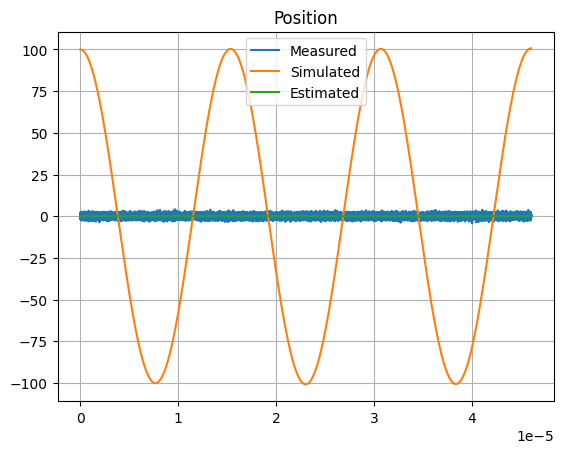

In [147]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states[:])
plt.plot(t, new_states[:,0])
plt.plot(t, estimated_states[:,0])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()

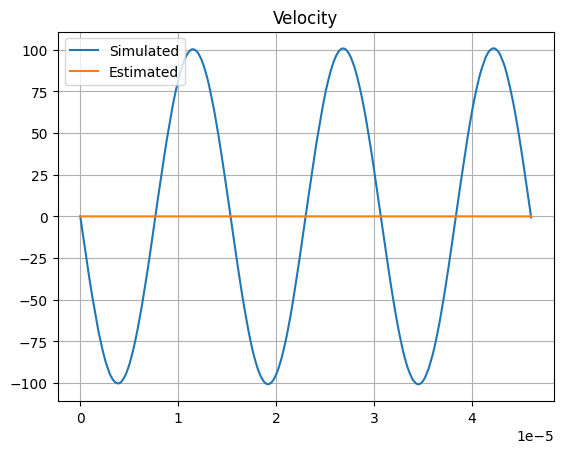

In [148]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], new_states[:,1])
plt.plot(t[:], estimated_states[:,1])
plt.grid()
plt.legend(['Simulated', 'Estimated'])
plt.show()

In [137]:
kalman.error_covariance_aposteriori[-1]

matrix([[0.00039308, 0.00302974],
        [0.00302974, 0.04724754]])

In [112]:
kalman.error_covariance_aposteriori[-1]

matrix([[0.00311051, 0.01183824],
        [0.01183824, 0.09337066]])